In [8]:
import numpy as np 
import matplotlib.pyplot as plt 

class BernoulliBandit:
    """ 伯努利多臂老虎机,输入K表示拉杆个数 """
    def __init__(self, K):
        self.probs = np.random.uniform(size=K)      # 随机生成K个0～1的数,作为拉动每根拉杆的获奖
        # 概率
        self.best_idx = np.argmax(self.probs)       # 获奖概率最大的拉杆
        self.best_prob = self.probs[self.best_idx]  # 最大的获奖概率
        self.K = K

    def step(self, k):
        # 当玩家选择了k号拉杆后,根据拉动该老虎机的k号拉杆获得奖励的概率返回1（获奖）或0（未获奖）
        if np.random.rand() < self.probs[k]:
            return 1
        else:
            return 0
        
np.random.seed(1)
K = 10 
bandit_10_arm = BernoulliBandit(K)
print("随机生成了一个%d老虎机"% K)
print("获胜概率最大的拉杆%d号，其获奖概率为%.4f"% (bandit_10_arm.best_idx,bandit_10_arm.best_prob))

随机生成了一个10老虎机
获胜概率最大的拉杆1号，其获奖概率为0.7203


接下来我们用一个 Solver 基础类来实现上述的多臂老虎机的求解方案。根据前文的算法流程，我们需要实现下列函数功能：根据策略选择动作、根据动作获取奖励、更新期望奖励估值、更新累积懊悔和计数。在下面的 MAB 算法基本框架中，我们将根据策略选择动作、根据动作获取奖励和更新期望奖励估值放在 run_one_step() 函数中，由每个继承 Solver 类的策略具体实现。而更新累积懊悔和计数则直接放在主循环 run() 中。

In [9]:
class Solver:
    """ 多臂老虎机算法基本框架 """
    def __init__(self, bandit):
        self.bandit = bandit
        self.counts = np.zeros(self.bandit.K)  # 每根拉杆的尝试次数
        self.regret = 0.  # 当前步的累积懊悔
        self.actions = []  # 维护一个列表,记录每一步的动作
        self.regrets = []  # 维护一个列表,记录每一步的累积懊悔

    def update_regret(self, k):
        # 计算累积懊悔并保存,k为本次动作选择的拉杆的编号
        self.regret += self.bandit.best_prob - self.bandit.probs[k]
        self.regrets.append(self.regret)

    def run_one_step(self):
        # 返回当前动作选择哪一根拉杆,由每个具体的策略实现
        raise NotImplementedError

    def run(self, num_steps):
        # 运行一定次数,num_steps为总运行次数
        for _ in range(num_steps):
            k = self.run_one_step()
            self.counts[k] += 1
            self.actions.append(k)
            self.update_regret(k)

ϵ-贪心算法

In [10]:
class EpsilonGreedy(Solver):
    """ epsilon贪婪算法,继承Solver类 """
    def __init__(self, bandit, epsilon=0.01, init_prob=1.0):
        super(EpsilonGreedy, self).__init__(bandit)
        self.epsilon = epsilon
        #初始化拉动所有拉杆的期望奖励估值
        self.estimates = np.array([init_prob] * self.bandit.K)

    def run_one_step(self):
        if np.random.random() < self.epsilon:
            k = np.random.randint(0, self.bandit.K)  # 随机选择一根拉杆
        else:
            k = np.argmax(self.estimates)  # 选择期望奖励估值最大的拉杆
        r = self.bandit.step(k)  # 得到本次动作的奖励
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])
        return k

epsilon-贪婪算法的累积懊悔为： 25.526630933945313


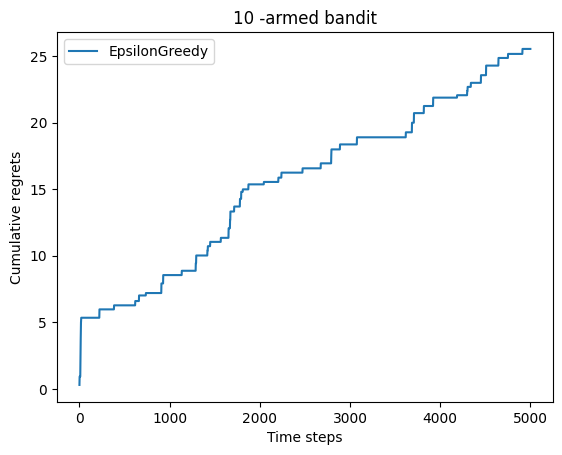

In [11]:
def plot_results(solvers, solver_names):
    """生成累积懊悔随时间变化的图像。输入solvers是一个列表,列表中的每个元素是一种特定的策略。
    而solver_names也是一个列表,存储每个策略的名称"""
    for idx, solver in enumerate(solvers):
        time_list = range(len(solver.regrets))
        plt.plot(time_list, solver.regrets, label=solver_names[idx])
    plt.xlabel('Time steps')
    plt.ylabel('Cumulative regrets')
    plt.title('%d -armed bandit' % solvers[0].bandit.K)
    plt.legend()
    plt.show()


np.random.seed(1)
epsilon_greedy_solver = EpsilonGreedy(bandit_10_arm, epsilon=0.01)
epsilon_greedy_solver.run(5000)
print('epsilon-贪婪算法的累积懊悔为：', epsilon_greedy_solver.regret)
plot_results([epsilon_greedy_solver], ["EpsilonGreedy"])

通过上面的实验可以发现，在经历了开始的一小段时间后，-贪婪算法的累积懊悔几乎是线性增长的。这是  时的结果，因为一旦做出了随机拉杆的探索，那么产生的懊悔值是固定的。其他不同的  取值又会带来怎样的变化呢？我们继续使用该 10 臂老虎机，我们尝试不同的参数，查看相应的实验结果

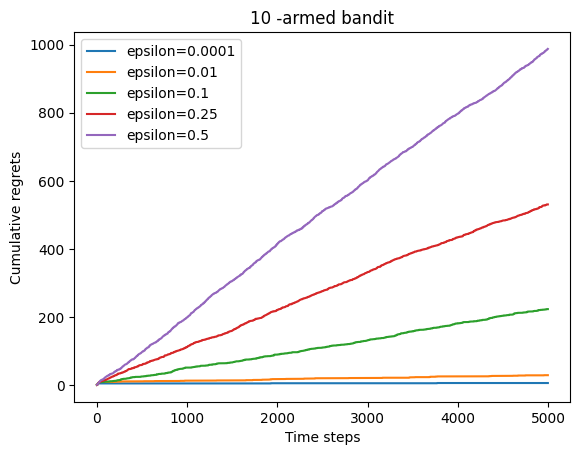

In [12]:
np.random.seed(0)
epsilons = [1e-4, 0.01, 0.1, 0.25, 0.5]
epsilon_greedy_solver_list = [
    EpsilonGreedy(bandit_10_arm, epsilon=e) for e in epsilons
]
epsilons_greedy_solver_name = ["epsilon={}".format(e)for e in epsilons]
for solver in epsilon_greedy_solver_list:
    solver.run(5000)

plot_results(epsilon_greedy_solver_list,epsilons_greedy_solver_name)


epsilon值衰减的贪婪算法的累积懊悔为： 10.114334931260183


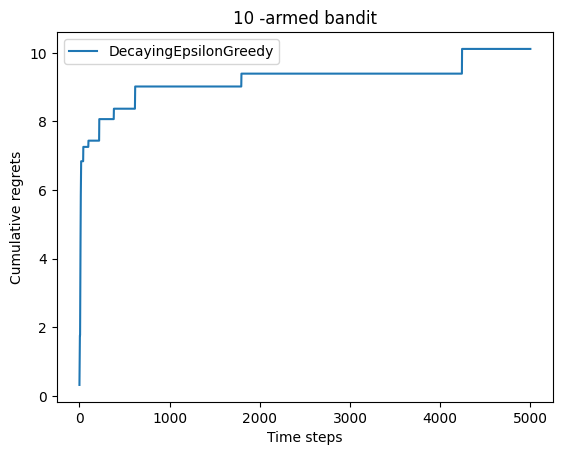

In [15]:
class DecayingEpsilonGreedy(Solver):
    """ epsilon值随时间衰减的epsilon-贪婪算法,继承Solver类 """
    def __init__(self, bandit, init_prob=1.0):
        super(DecayingEpsilonGreedy, self).__init__(bandit)
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.total_count = 0

    def run_one_step(self):
        self.total_count += 1
        if np.random.random() < 1 / self.total_count:  # epsilon值随时间衰减
            k = np.random.randint(0, self.bandit.K)
        else:
            k = np.argmax(self.estimates)

        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r - self.estimates[k])

        return k


np.random.seed(1)
decaying_epsilon_greedy_solver = DecayingEpsilonGreedy(bandit_10_arm)
decaying_epsilon_greedy_solver.run(5000)
print('epsilon值衰减的贪婪算法的累积懊悔为：', decaying_epsilon_greedy_solver.regret)
plot_results([decaying_epsilon_greedy_solver], ["DecayingEpsilonGreedy"])

## 上置信界（upper confidence bound，UCB）

上置信界算法的累积懊悔为： 70.45281214197854


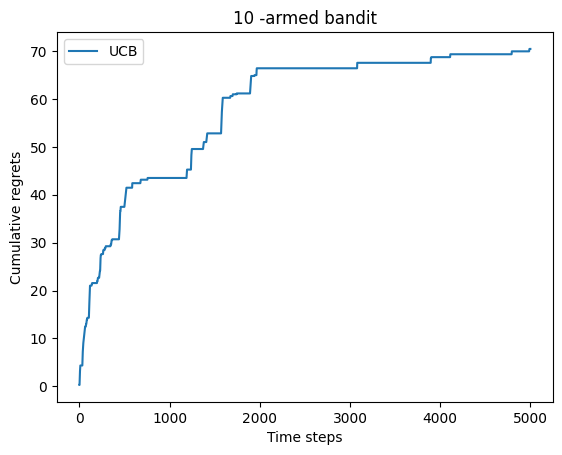

In [20]:
class UCB(Solver):
    """ UCB算法,继承Solver类 """
    def __init__(self, bandit, coef, init_prob=1.0):
        super(UCB,self).__init__(bandit)
        self.total_count = 0 
        self.estimates = np.array([init_prob] * self.bandit.K)
        self.coef = coef 
        
    def run_one_step(self):
        self.total_count += 1
        ucb = self.estimates + self.coef*np.sqrt(
            np.log(self.total_count) / (2 * (self.counts + 1)))
        k = np.argmax(ucb)
        r = self.bandit.step(k)
        self.estimates[k] += 1. / (self.counts[k] + 1) * (r -self.estimates[k])
        return k

np.random.seed(1)
coef = 1
UCB_solver = UCB(bandit_10_arm,coef)
UCB_solver.run(5000)
print('上置信界算法的累积懊悔为：',UCB_solver.regret)
plot_results([UCB_solver],['UCB'])